# Preprocessing of CM2.6 input for air-sea flux calculation


In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
import json
import gcsfs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar

from scale_aware_air_sea.utils import to_zarr_split, smooth_inputs_dataset
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26

In [3]:
fs = gcsfs.GCSFileSystem()

version = 'v0.6.1'
suffix = '_test'
# suffix = ''
# set up save targets
bucket = 'gs://leap-persistent/jbusecke' # equivalent to os.environ['PERSISTENT_BUCKET'], but this should work for all collaborators
output_path = f"{bucket}/scale-aware-air-sea/smoothed/CM26_smoothed_{version}{suffix}.zarr"
output_mapper = fs.get_mapper(output_path)

In [4]:
output_mapper.root

'leap-persistent/jbusecke/scale-aware-air-sea/smoothed/CM26_smoothed_v0.6.1_test.zarr'

In [5]:
ds_merged  = load_and_combine_cm26(fs, inline_array=True)
ds_merged

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Smooth input fields

In [6]:
filter_scale = 50

smooth_vars = ['u_relative', 'v_relative', 'surface_temp', 't_ref', 'q_ref', 'slp', 'u_ocean', 'v_ocean', 'u_ref', 'v_ref']

# smooth the whole dataset with the new method
ds_merged_smoothed = smooth_inputs_dataset(ds_merged[smooth_vars], ['yt_ocean', 'xt_ocean'], filter_scale)

# add the smoothed variables to the original dataset
for var in smooth_vars:
    ds_merged[var+'_smoothed'] = ds_merged_smoothed[var]
    
# also rebuild a second relative wind from only ocean smoothed velocities
ds_merged['u_relative_smoothed_ocean_only'] = ds_merged['u_ref'] - ds_merged['u_ocean_smoothed']
ds_merged['v_relative_smoothed_ocean_only'] = ds_merged['v_ref'] - ds_merged['v_ocean_smoothed']

ds_merged['u_relative_smoothed_atmos_only'] = ds_merged['u_ref_smoothed'] - ds_merged['u_ocean']
ds_merged['v_relative_smoothed_atmos_only'] = ds_merged['v_ref_smoothed'] - ds_merged['v_ocean']

ds_merged

<xarray.Dataset>
Dimensions:                         (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time                            (time) object 0181-01-01 12:00:00 ... 020...
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables: (12/25)
    slp                             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind                            (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                              ...
    u_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Some sanity checks with the data before large batch save

### Check that the nanmask is uniform across variables
See https://github.com/ocean-transport/scale-aware-air-sea/issues/46



In [7]:
# roi = dict(xt_ocean=slice(-82, -77), yt_ocean=slice(22,27))

# plt.figure()
# ds_merged['u_relative'].isel(time=0).sel(**roi).plot(robust=True)
# plt.show()

# plt.figure()
# ds_merged['u_relative_smoothed'].isel(time=0).sel(**roi).plot(robust=True)
# plt.show()

# plt.figure()
# ds_merged['surface_temp_smoothed'].isel(time=0).sel(**roi).plot(robust=True)
# plt.show()

In [8]:
# prune dataset for saving
keep_vars = [
    'slp_smoothed', 'surface_temp_smoothed',
    'u_relative_smoothed','v_relative_smoothed',
    'u_relative_smoothed_ocean_only','v_relative_smoothed_ocean_only',
    'u_relative_smoothed_atmos_only','v_relative_smoothed_atmos_only',
    't_ref_smoothed', 'q_ref_smoothed'
]
# keep_vars = ['surface_temp_smoothed']
ds_save = ds_merged[keep_vars]

if suffix == '_test':
    ds_save = ds_save.isel(time=slice(0,300))
ds_save

<xarray.Dataset>
Dimensions:                         (time: 300, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time                            (time) object 0181-01-01 12:00:00 ... 018...
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables:
    slp_smoothed                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp_smoothed           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [9]:
ds_save.nbytes/1e12

0.1166400528

## Set up a legit dask cluster

In [10]:
# distributed does not like these long tasks (>40s) we produce. 
# Lets see if we can tune that (!YES!):
import dask

logging_config = {
    "version": 1,
    "handlers": {
        "file": {
            "class": "logging.handlers.RotatingFileHandler",
            "filename": "output_test.log",
            "level": "DEBUG",
        },
        "console": {
            "class": "logging.StreamHandler",
            "level": "DEBUG",
        }
    },
    "loggers": {
        "distributed.worker": {
            "level": "DEBUG",
            "handlers": ["file", "console"],
        },
        "distributed.scheduler": {
            "level": "DEBUG",
            "handlers": ["file", "console"],
        }
    }
}
dask.config.config['logging'] = logging_config

dask.config.set(
    {
        # "distributed.comm.timeouts.tcp": "360s",
        # "distributed.comm.timeouts.connect": "360s",
        # Account for even longer duration of the taper filter?
        "distributed.scheduler.allowed-failures" : 2, # not sure if this will help
        "distributed.comm.timeouts.tcp": "6000s",
        "distributed.comm.timeouts.connect": "6000s",
        "distributed.deploy.lost-worker-timeout": "6000s",
        "distributed.scheduler.idle-timeout": "6000s"
    }
)

print(dask.config.get('logging'))

# try a local cluster for testing
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=4)
client = Client(cluster)
client

# from dask_gateway import Gateway

# gateway = Gateway()

# # close existing clusters
# open_clusters = gateway.list_clusters()
# print(list(open_clusters))
# if len(open_clusters)>0:
#     for c in open_clusters:
#         cluster = gateway.connect(c.name)
#         cluster.shutdown()  

# options = gateway.cluster_options()
# options.worker_memory = 50 # Could proabably reduce this to something like 40, but I think that doesnt actually free up space...
# options.worker_cores = 12 # could probably handle 12 here...

# options.environment = dict(
#     DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
# )

# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# client = cluster.get_client()
# # cluster.adapt(10,200)
# cluster.scale(4) # for testing
# client

{'version': 1, 'handlers': {'file': {'class': 'logging.handlers.RotatingFileHandler', 'filename': 'output_test.log', 'level': 'DEBUG'}, 'console': {'class': 'logging.StreamHandler', 'level': 'DEBUG'}}, 'loggers': {'distributed.worker': {'level': 'DEBUG', 'handlers': ['file', 'console']}, 'distributed.scheduler': {'level': 'DEBUG', 'handlers': ['file', 'console']}}}


2022-12-22 19:07:55,260 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-dni4dyy4', purging
2022-12-22 19:07:55,260 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-fzvapbsp', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/air_sea_project/proxy/8787/status,
Dashboard: /user/jbusecke/air_sea_project/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36389,Workers: 4
Dashboard: /user/jbusecke/air_sea_project/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.87 GiB
Comm: tcp://127.0.0.1:35789,Total threads: 4
Dashboard: /user/jbusecke/air_sea_project/proxy/46147/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:45207,


In [11]:
if suffix == '_test':
    # only works on small subsets, otherwise see below.
    ds_save.isel(time=slice(0,3)).to_zarr(output_mapper, mode='w')
else:
    to_zarr_split(ds_save, output_mapper, split_interval=1000) #formerly 1000 split

In [12]:
ds = xr.open_dataset(output_mapper, engine='zarr', chunks={}, consolidated=True)
ds

<xarray.Dataset>
Dimensions:                         (time: 3, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time                            (time) object 0181-01-01 12:00:00 ... 018...
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables:
    q_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp_smoothed                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp_smoothed           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [13]:
print(output_mapper.root)

leap-persistent/jbusecke/scale-aware-air-sea/smoothed/CM26_smoothed_v0.6.1_test.zarr


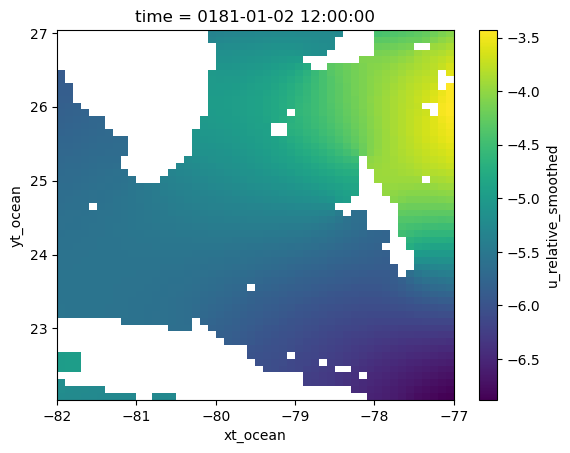

In [14]:
roi = dict(xt_ocean=slice(-82, -77), yt_ocean=slice(22,27))
ds.isel(time=-2)['u_relative_smoothed'].sel(**roi).plot()